In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pwlf
import pathlib
import math
import numpy as np

In [2]:
src = pathlib.Path().cwd().parent.parent / 'data' / 'processed'
ref = pathlib.Path().cwd().parent.parent / 'reference'

In [3]:
no_test_pos = pd.read_csv(
    src / 'no-test' / 'no-test-pos.csv', index_col='date_report',
    parse_dates=True)

no_test_pos_by_adh = pd.read_csv(
    src / 'no-test' / 'no-test-pos-by-adh.csv', index_col='date_report',
    parse_dates=True)

addiv = pd.read_csv(
    ref / 'addiv.csv',
    usecols=['id_addiv', 'name_addiv'])

In [4]:
# no_test.index = pd.to_datetime(no_test.index)
no_test_pos['no_test_pos_rollmean7d'] = no_test_pos['no_test_pos'].rolling(7).mean()
df1 = (
       no_test_pos_by_adh.groupby(['addr_dist_home'])
       ['no_test_pos']
       .rolling(7).mean()
       .to_frame('no_test_pos_rollmean7d')
       .reset_index()
       .set_index('date_report')
       )

no_test_pos_by_adh = (
    no_test_pos_by_adh
    .merge(df1, how='left', on=['date_report', 'addr_dist_home'])
    .reset_index()
    .merge(addiv, how='left', left_on='addr_dist_home', right_on='id_addiv')
    .drop(columns = 'addr_dist_home')
    .rename(columns={'name_addiv': 'addr_dist_home'})
    .set_index('date_report')
      )

# foo = (
#     no_test_pos_by_adh
#     .reset_index()
#     .merge(addiv, how='left', left_on='addr_dist_home', right_on='id_addiv')
#     .drop(columns = 'addr_dist_home')
#     .rename(columns={'name_addiv': 'addr_dist_home'})
#     .set_index('date')
# )

no_test_pos_by_adh['addr_dist_home'] = no_test_pos_by_adh['addr_dist_home'].astype('str')


In [5]:
# shift left
no_test_pos['no_test_pos_rollmean7d_sl'] = no_test_pos.no_test_pos_rollmean7d.shift(-10)
no_test_pos['no_test_pos_sl'] = no_test_pos.no_test_pos.shift(-10)
no_test_pos = no_test_pos.loc[:'2021-12-01',]

In [6]:
no_test_pos.tail(10)
# no_test_pos_by_adh.addr_dist_home.unique()
# addiv.info()
# no_test_pos_by_adh.info()
# foo
# no_test.index

,no_test_pos,no_test_pos_rollmean7d,no_test_pos_rollmean7d_sl,no_test_pos_sl
date_report,,,,
2021-11-22,5594.0,4220.714286,5118.000000,5056.0
2021-11-23,5466.0,4400.285714,5013.428571,4520.0
2021-11-24,5047.0,4440.285714,4956.714286,3826.0
2021-11-25,5673.0,4700.428571,4942.714286,3663.0
2021-11-26,5252.0,4871.000000,4748.142857,4858.0
2021-11-27,4223.0,4977.000000,4566.571429,4611.0
2021-11-28,3761.0,5002.285714,4405.571429,4305.0
2021-11-29,6220.0,5091.714286,4296.714286,4294.0
2021-11-30,5882.0,5151.142857,4179.000000,3696.0


In [7]:
# Plot no_case
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.plot(no_case.index, no_case.no_case, linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [8]:
# Plot log no_case
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot(no_case.index, (no_case.no_case_rollmean7d).transform(math.log), linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# # ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [9]:
# Model config
beta_dict = {}
slope_dict = {}
x_dict = {}
y_dict = {}
x_hat_dict = {}
y_hat_dict = {}
predicted_var_dict = {}
ub_dict = {}
lb_dict = {}
xlabels_dict = {}
plot_title_dict = {}
no_test_pos_col = 'no_test_pos_rollmean7d_sl'
forecast_horizon = 9
policy_change = [no_test_pos.index.min(),
                 '2021-05-31', # chi thi 15, 16
                 '2021-06-14', # chi thi 15
                 '2021-06-19', # chi thi 10
                 '2021-07-09', # chi thi 16
                 '2021-07-19', # chi thi 16
                 '2021-07-27', # ngung xn hang loat
                 '2021-08-01', # chi thi 16
                 '2021-08-10', # quan huyen k fit
                 '2021-08-15',
                 '2021-08-23', # phong toa
                 '2021-10-01',
                 no_test_pos.index.max()
                ]

In [10]:
# Forecast no_test_pos
# forecast_horizon = 15
# policy_change = [no_test_pos.index.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
#                  '2021-07-09', '2021-07-19', '2021-08-01', no_test_pos.index.max()]

x = (no_test_pos.index - no_test_pos.index.min()) / pd.Timedelta(1, unit='d')
y = no_test_pos[no_test_pos_col].replace(0, np.nan).transform(math.log).fillna(0)
x0 = (pd.to_datetime(policy_change) - no_test_pos.index.min()) / pd.Timedelta(1, unit='d')
xlabels = pd.date_range(
    no_test_pos.index.min(),
    no_test_pos.index.max() + pd.Timedelta(days=forecast_horizon-1)
).strftime('%d-%m')

model = pwlf.PiecewiseLinFit(x, y)
model.fit_with_breaks(x0)

x_hat = np.arange(min(x), max(x) + forecast_horizon)
y_hat = model.predict(x_hat)

predicted_var = model.prediction_variance(x_hat)
ub = y_hat + 1.96*np.sqrt(predicted_var)
lb = y_hat - 1.96*np.sqrt(predicted_var)

# Add result to dict
beta_dict['tphcm'] = list(model.beta)
slope_dict['tphcm'] = list(model.calc_slopes())
x_dict['tphcm'] = list(x)
y_dict['tphcm'] = list(y)
x_hat_dict['tphcm'] = list(x_hat)
y_hat_dict['tphcm'] = list(y_hat)
predicted_var_dict['tphcm'] = list(predicted_var)
ub_dict['tphcm'] = list(ub)
lb_dict['tphcm'] = list(lb)
xlabels_dict['tphcm'] = list(xlabels)
plot_title_dict['tphcm'] = 'TP HCM'

In [11]:
# dir(model)
# slope_dict
model.r_squared()

0.9712597597092287

In [12]:
# beta_dict['tphcm']

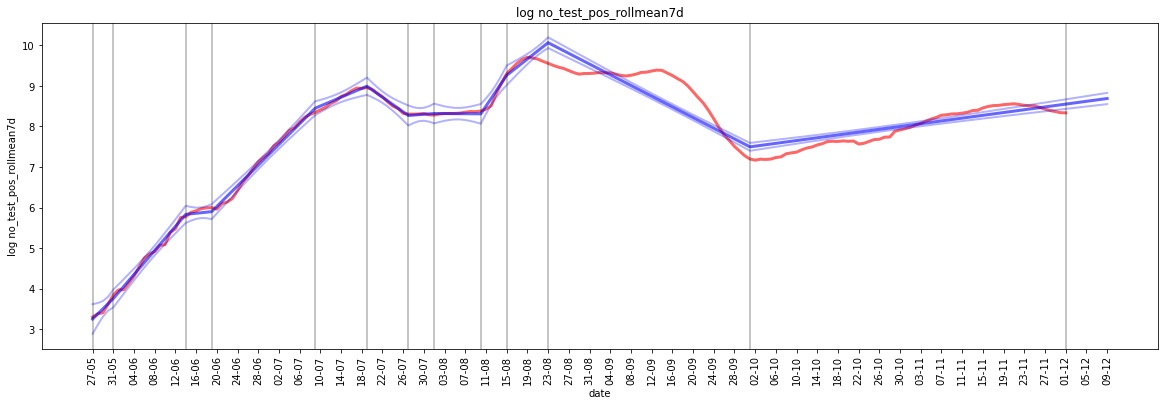

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel('log no_test_pos_rollmean7d')
ax.set_xlabel('date')
ax.set_title('log no_test_pos_rollmean7d')
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)

xlabels = pd.date_range(
    no_test_pos.index.min(),
    no_test_pos.index.max() + pd.Timedelta(days=forecast_horizon - 1)
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)
ax.locator_params(axis='x', tight=True, nbins=60)

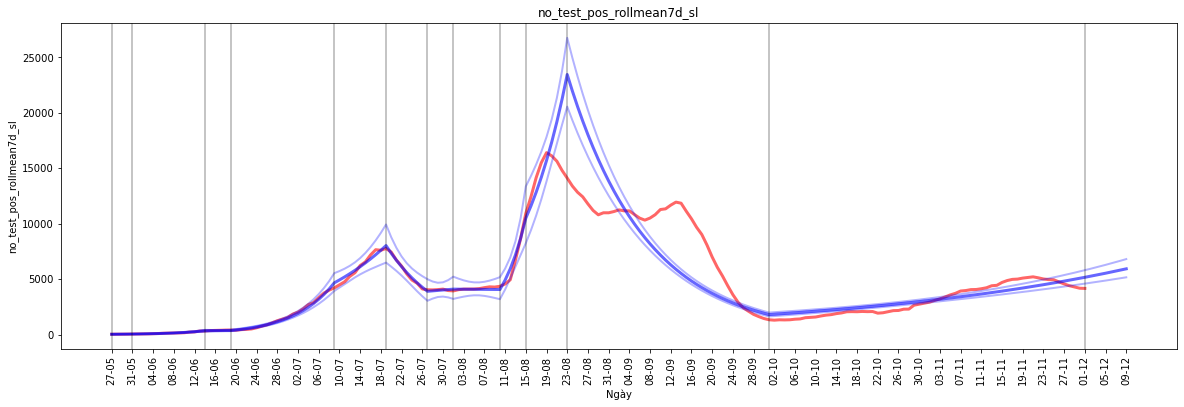

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
# ax.plot(x, no_test_pos.no_test_pos_sl, linewidth=3, color='orange', alpha=0.5)
ax.plot(x_hat,  np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat,  np.exp(ub), linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat,  np.exp(lb), linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel(no_test_pos_col)
ax.set_title(no_test_pos_col)
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)
ax.set_xlabel('Ngày')
xlabels = pd.date_range(
    no_test_pos.index.min(),
    no_test_pos.index.max() + pd.Timedelta(days=forecast_horizon -1 )
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)
# ax.set_ylim([0, 10000])
ax.locator_params(axis='x', tight=True, nbins=60)
# plt.savefig(
#     src / 'pwlf-from-no-test' / 'no-test.png',
#     transparent = True)
# plt.close(fig)

In [93]:
date_report = pd.date_range(
    no_test_pos.index.min(),
    no_test_pos.index.max() + pd.Timedelta(days=forecast_horizon-1)
)
predicted_no_test_pos = pd.DataFrame({
    'date_report': date_report,
    'no_test_pos_predicted': np.exp(y_hat_dict['tphcm']),
    'lb': np.exp(lb_dict['tphcm']),
    'ub': np.exp(ub_dict['tphcm'])
})
predicted_no_test_pos.to_csv(src / 'pwlf-from-no-test' / 'predicted-no-test-pos.csv')
predicted_no_test_pos.to_excel(src / 'pwlf-from-no-test' / 'predicted-no-test-pos.xlsx')

In [23]:
# np.exp(y_hat_dict['tphcm'][101])
# np.exp(ub_dict['tphcm'][101])
# np.exp(lb_dict['tphcm'][101])
# xlabels_dict['tphcm'][107]
# rs = model.r_squared()
# rs

'11-09'

In [42]:
# no_case_by_adh[(no_case_by_adh.addr_dist_home == 'HUYEN BINH CHANH')
#                & (no_case_by_adh.date_report > '2021-06-30')]
# foo['no_case_rollmean7d_sl'] = foo.no_case_rollmean7d.shift(-10)
# foo = foo.set_index('date_report')
# foo = foo.loc[:'2021-08-11',]
# foo.tail(15)
# foo = list(no_case_by_adh['addr_dist_home'].unique())
# foo = foo.sort()
# sorted(foo)

In [94]:
# Forecast log no_test_pos by adh
def forecast_no_test_pos_by_group(data, group, no_test_pos_col, forecast_horizon=7):
    unique = list(data[group].unique())
    for u in unique:
        df = data[data[group] == u]
#         df['date'] = pd.to_datetime(df.date)
#         df = df.set_index('date')
        df = df.loc[:'2021-12-01',] # for shift data only
#         df.loc[:,'date'] = pd.to_datetime(df.index)
        key = u.lower().replace(' ', '')
#     output_dir = src / 'predicted-no-case-from-no-case-data'
#     prefix_1 = 'predicted-log-no-case-'
#     prefix_2 = 'by-adh-'
#     filename = prefix_1 + prefix_2 + u.lower().replace(' ', '') + '.png'
        # Run model PiecewiseLinFit with policy_change break
        x = (df.index - df.index.min()) / pd.Timedelta(1, unit='d')
        y = df[no_test_pos_col].replace(0, np.nan).transform(math.log).fillna(0)
        x0 = (pd.to_datetime(policy_change) - df.index.min()) / pd.Timedelta(1, unit='d')
        xlabels = pd.date_range(
            df.index.min(),
            df.index.max() + pd.Timedelta(days=forecast_horizon-1)
        ).strftime('%d-%m')
        model = pwlf.PiecewiseLinFit(x, y)
        model.fit_with_breaks(x0)
        x_hat = np.arange(min(x), max(x) + forecast_horizon)
        y_hat = model.predict(x_hat)
        predicted_var = model.prediction_variance(x_hat)
        ub = y_hat + 1.96*np.sqrt(predicted_var)
        lb = y_hat - 1.96*np.sqrt(predicted_var)
        # Save result to dict
        beta_dict[key] = list(model.beta)
        slope_dict[key] = list(model.calc_slopes())
        x_dict[key] = list(x)
        y_dict[key] = list(y)
        x_hat_dict[key] = list(x_hat)
        y_hat_dict[key] = list(y_hat)
        predicted_var_dict[key] = list(predicted_var)
        ub_dict[key] = list(ub)
        lb_dict[key] = list(lb)
        xlabels_dict[key] = list(xlabels)
        plot_title_dict[key] = u

def plot_forecast_no_test_pos_by_group(exp=True, sharex=True, nrow=8, ncol=3, 
                                   xstart=1, xend=25, ylim=700, figsize=(18, 24)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    plt.tight_layout(h_pad=5)
#     fig.suptitle('Title here')
    keys = sorted(list(x_dict.keys())[xstart:xend])
    if exp:
        for k in range(len(keys)):
            r = k // ncol
            c = k % ncol
            ax[r, c].plot(x_dict[keys[k]], np.exp(y_dict[keys[k]]), linewidth=2, color='red', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(y_hat_dict[keys[k]]), linewidth=2, color='blue', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(ub_dict[keys[k]]), linewidth=1, color='blue', alpha=0.3)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(lb_dict[keys[k]]), linewidth=1, color='blue', alpha=0.3)
            ax[r, c].fill_between(x_hat_dict[keys[k]], np.exp(lb_dict[keys[k]]), np.exp(ub_dict[keys[k]]),
                                  color='blue', alpha=0.1)
            ax[r, c].title.set_text(plot_title_dict[keys[k]])
            ax[r, c].set_ylim([0, ylim])
    #         ax[r, c].set_ylabel('Log Số ca mới')
    #         ax[r, c].set_xlabel('Ngày')
            ax[r, c].set_xticks(x_hat_dict[keys[k]])
            ax[r, c].set_xticklabels(xlabels_dict[keys[k]])
            ax[r, c].tick_params(axis='x', labelrotation=90)
            ax[r, c].locator_params(tight=True, nbins=11)

    else:
        for k in range(len(keys)):
            r = k // ncol
            c = k % ncol
            ax[r, c].plot(x_dict[keys[k]], y_dict[keys[k]], linewidth=2, color='red', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], y_hat_dict[keys[k]], linewidth=2, color='blue', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], ub_dict[keys[k]], linewidth=1, color='blue', alpha=0.3)
            ax[r, c].plot(x_hat_dict[keys[k]], lb_dict[keys[k]], linewidth=1, color='blue', alpha=0.3)
            ax[r, c].fill_between(x_hat_dict[keys[k]], lb_dict[keys[k]], ub_dict[keys[k]], color='blue', alpha=0.1)
            ax[r, c].title.set_text(plot_title_dict[keys[k]])
            ax[r, c].set_ylim([0, ylim])
            ax[r, c].set_xticks(x_hat_dict[keys[k]])
            ax[r, c].set_xticklabels(xlabels_dict[keys[k]])
            ax[r, c].tick_params(axis='x', labelrotation=90)
            ax[r, c].locator_params(tight=True, nbins=11)
        
# DO NOT DELETE THIS
#     fig, ax = plt.subplots(figsize=(20, 6))
#     ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
#     ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
#     ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
#     ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
#     ax.set_ylabel('Log Số ca mới')
#     ax.set_xlabel('Ngày')
#     ax.set_xticks(x_hat)
#     ax.set_xticklabels(xlabels)
#     ax.tick_params(axis='x', labelrotation=90)
#     ax.set_title('Log số ca mới & Log số ca mới dự báo ' + u)
#     for i in x0:
#         ax.axvline(i, color='black', alpha=0.3)

#     plt.savefig(
#         output_dir / filename,
#         transparent = True)
#     plt.close(fig)



In [95]:
forecast_no_test_pos_by_group(
    no_test_pos_by_adh,
    no_test_pos_col=no_test_pos_col,
    group='addr_dist_home',
    forecast_horizon=forecast_horizon)
plot_forecast_no_test_pos_by_group(
    ylim=1000,
    xstart=1,
    xend=26,
    nrow=9,
    ncol=3,)

# plt.savefig(
#     src / 'pwlf-from-no-test' / 'no-test-by-adh.png',
#     transparent = True)
# plt.close(fig)

KeyError: 'no_test_pos_rollmean7d_sl'

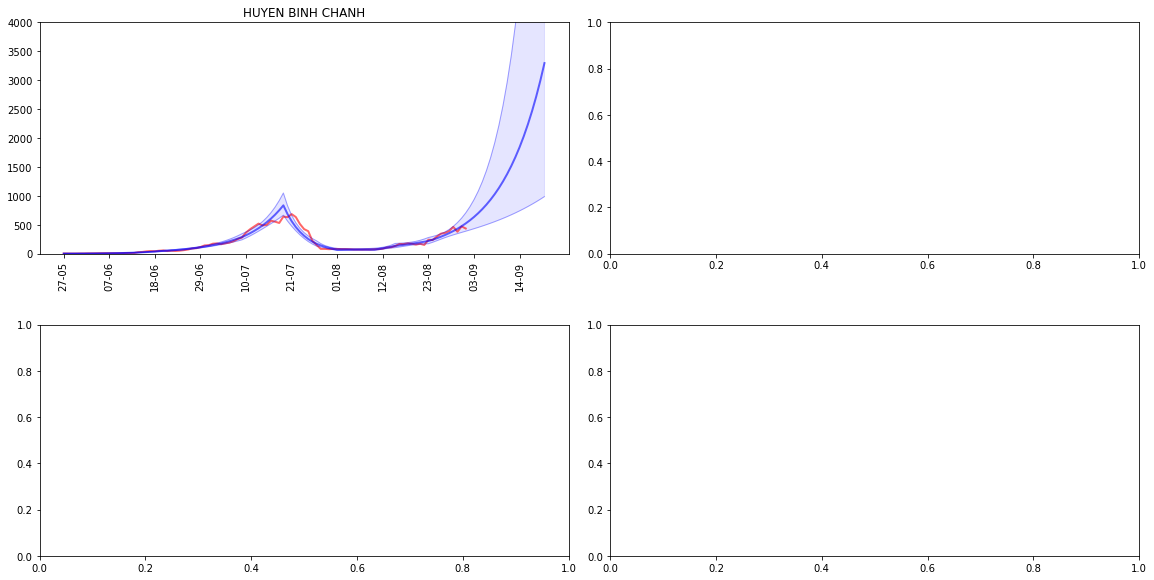

In [26]:
plot_forecast_no_case_by_group(nrow=2, ncol=2, xstart=22, xend=23, ylim=4000, figsize=(16, 8))

<ipython-input-18-e2246a8359c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_case_rollmean7d_sl'] = df.no_case_rollmean7d.shift(-10) # for shift data only
<ipython-input-18-e2246a8359c3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


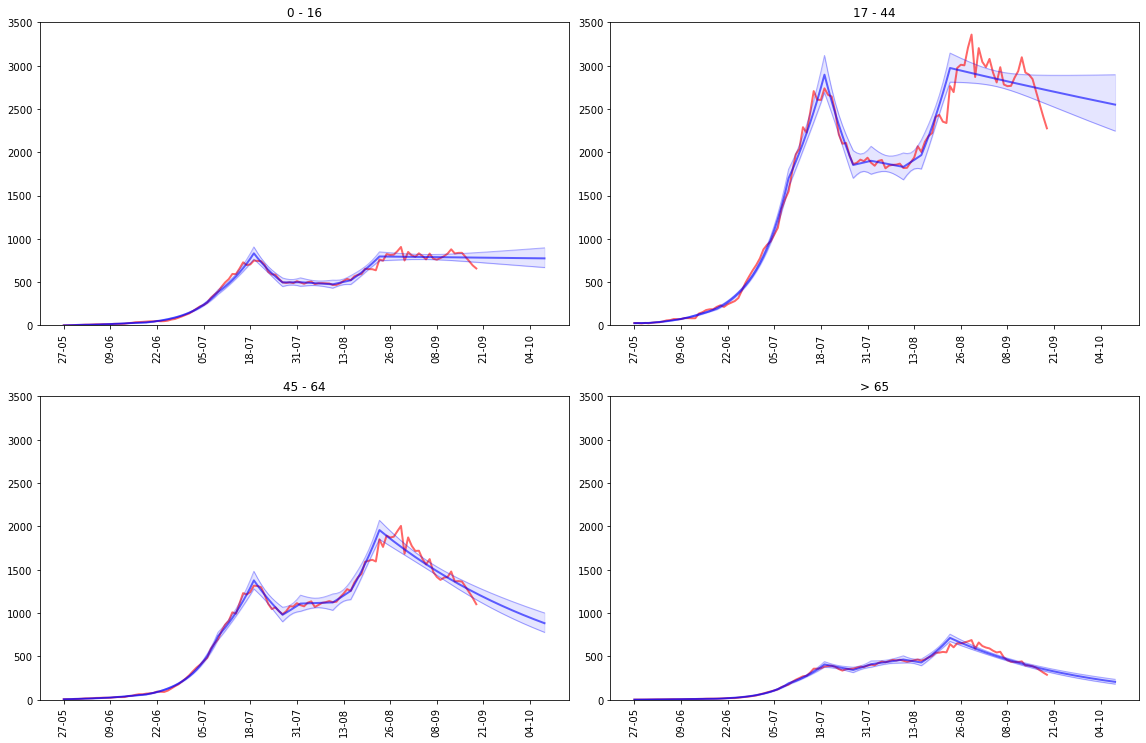

In [27]:
forecast_no_case_by_group(
    no_case_by_ag,
    no_case_col=no_case_col,
    group='age_group',
    forecast_horizon=forecast_horizon)
plot_forecast_no_case_by_group(nrow=2, ncol=2, xstart=25, xend=29, ylim=3500, figsize=(16, 10))

plt.savefig(
    src / 'pwlf-from-no-case' / 'no-case-by-ag.png',
    transparent = True)
plt.close(fig)

<ipython-input-18-e2246a8359c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_case_rollmean7d_sl'] = df.no_case_rollmean7d.shift(-10) # for shift data only
<ipython-input-18-e2246a8359c3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


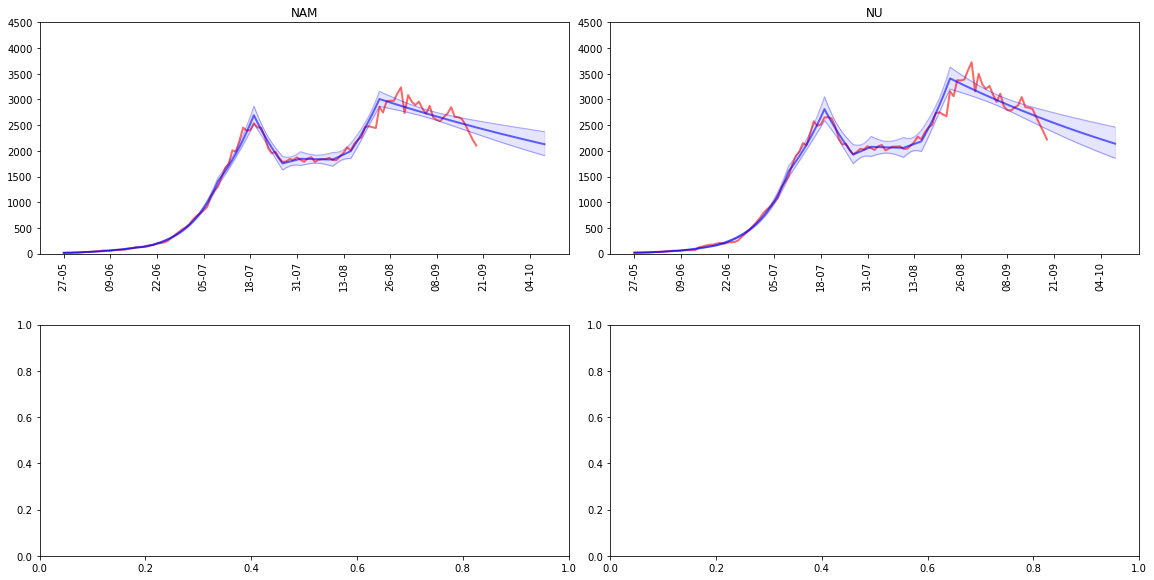

In [30]:
forecast_no_case_by_group(
    no_case_by_sex,
    no_case_col=no_case_col,
    group='sex',
    forecast_horizon=forecast_horizon)

plot_forecast_no_case_by_group(nrow=2, ncol=2, xstart=29, xend=31, ylim=4500, figsize=(16, 8))

plt.savefig(
    src / 'pwlf-from-no-case' / 'no-case-by-sex.png',
    transparent = True)
plt.close(fig)

In [22]:
# y hat, ub, lb ngay 04/09
foo_yhat = np.exp(pd.DataFrame(y_hat_dict))
foo_ub = np.exp(pd.DataFrame(ub_dict))
foo_lb = np.exp(pd.DataFrame(lb_dict))
# pd.to_datetime(x_hat_dict).strftime('%d-%m-%Y')[:-1]
predicted_no_case = pd.concat([foo_yhat.loc[100], foo_ub.loc[100], foo_lb.loc[100]], axis=1)
predicted_no_case.columns = ['y_hat', 'ci_lower', 'ci_upper']
predicted_no_case
# predicted_no_case.to_csv(src / 'predicted-no-case-from-no-case-data' / 'predicted-no-case-2021-09-04.csv')
# xlabels_dict['tphcm'][100]

,y_hat,ci_lower,ci_upper
tphcm,5768.899352,5940.628465,5602.134510
quan01,153.255614,160.678569,146.175581
quan12,418.274039,446.219721,392.078530
quanthuduc,253.834287,284.418472,226.538892
quan09,108.158626,122.630228,95.394818
quangovap,110.799093,117.890208,104.134510
quanbinhthanh,321.284729,342.658422,301.244244
quantanbinh,381.709145,400.887529,363.448251
quantanphu,403.052888,428.348573,379.251014
quanphunhuan,132.347149,143.767087,121.834338


In [21]:
slope = pd.DataFrame(slope_dict).transpose()
slope.columns = pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]
r0 = np.exp(slope)

slope.to_csv(src / 'pwlf-from-no-test' / 'slope.csv')
r0.to_csv(src / 'pwlf-from-no-test' / 'r0.csv')
r0.to_excel(src / 'pwlf-from-no-test' / 'r0.xlsx')
# slope
r0

,27-05-2021,31-05-2021,14-06-2021,19-06-2021,09-07-2021,19-07-2021,27-07-2021,01-08-2021,10-08-2021,15-08-2021,23-08-2021
tphcm,1.259528,1.330889,1.055723,1.10708,1.143433,1.071699,0.978405,0.937817,1.015125,1.034882,1.011851


In [132]:
pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]

Index(['27-05-2021', '31-05-2021', '14-06-2021', '19-06-2021', '09-07-2021',
       '19-07-2021', '01-08-2021', '15-08-2021'],
      dtype='object')

In [21]:
# TODO fix this plot
# Forecast no_case by adh
unique = list(no_case_by_adh.addr_dist_home.unique())
for u in unique:
    df = no_case_by_adh[no_case_by_adh.addr_dist_home == u]
    df.loc[:,'date_report'] = pd.to_datetime(df.date_report)
    forecast_horizon = 15
    policy_change = [df.date_report.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
                     '2021-07-09', '2021-07-19', '2021-08-01', df.date_report.max()]

    output_dir = src / 'predicted-no-case-from-no-case-data'
    prefix_1 = 'predicted-no-case-'
    prefix_2 = 'by-adh-'
    filename = prefix_1 + prefix_2 + u.lower().replace(' ', '') + '.png'

    x = (df.date_report - df.date_report.min()) / pd.Timedelta(1, unit='d')
    y = df.no_case_ppop_rollmean7d.replace(0, np.nan).transform(math.log).fillna(0)
    x0 = (pd.to_datetime(policy_change) - df.date_report.min()) / pd.Timedelta(1, unit='d')
    xlabels = pd.date_range(
        df.date_report.min(),
        df.date_report.max() + pd.Timedelta(days=forecast_horizon-1)
    ).strftime('%d-%m')

    model = pwlf.PiecewiseLinFit(x, y)
    model.fit_with_breaks(x0)

    x_hat = np.arange(min(x), max(x) + forecast_horizon)
    y_hat = model.predict(x_hat)

    predicted_var = model.prediction_variance(x_hat)
    ub = y_hat + 1.96*np.sqrt(predicted_var)
    lb = y_hat - 1.96*np.sqrt(predicted_var)

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
    ax.plot(x_hat, np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
    ax.plot(x_hat, np.exp(ub), linewidth=2, color='blue', alpha=0.3)
    ax.plot(x_hat, np.exp(lb), linewidth=2, color='blue', alpha=0.3)
    ax.set_ylabel('Số ca mới')
    ax.set_xlabel('Ngày')
    ax.set_xticks(x_hat)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title('Số ca mới & Số ca mới dự báo ' + u)
    for i in x0:
        ax.axvline(i, color='black', alpha=0.3)

    plt.savefig(
        output_dir / filename,
        transparent = True)
    plt.close(fig)

/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [29]:
# Forecast no_case by adh
for key in y_hat_dict.keys():
    output_dir = src / 'predicted-no-case-from-no-case-data'
    prefix_1 = 'predicted-no-case-'
    prefix_2 = 'by-adh-'
    filename = prefix_1 + prefix_2 + plot_title_dict[key].lower().replace(' ', '') + '.png'
    x = x_dict[key]
    y = y_dict[key]
    x_hat = x_hat_dict[key]
    y_hat = y_hat_dict[key]
    ub = ub_dict[key]
    lb = lb_dict[key]
    title = plot_title_dict[key]
    xlabels = xlabels_dict[key]

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
    ax.plot(x_hat, np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
    ax.plot(x_hat, np.exp(ub), linewidth=2, color='blue', alpha=0.3)
    ax.plot(x_hat, np.exp(lb), linewidth=2, color='blue', alpha=0.3)
    ax.set_ylabel('Số ca mới')
    ax.set_xlabel('Ngày')
    ax.set_xticks(x_hat)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title('Số ca mới & Số ca mới dự báo ' + plot_title_dict[key])
    for i in x0:
        ax.axvline(i, color='black', alpha=0.3)

    plt.savefig(
        output_dir / filename,
        transparent = True)
    plt.close(fig)

In [25]:
for key in y_hat_dict.keys():
    print(key)

tphcm
quan01
quan12
quanthuduc
quan09
quangovap
quanbinhthanh
quantanbinh
quantanphu
quanphunhuan
quan02
quan03
quan10
quan11
quan04
quan05
quan06
quan08
quanbinhtan
quan07
huyencuchi
huyenhocmon
huyenbinhchanh
huyennhabe
huyencangio


In [30]:
# np.exp(y_hat)[82]
# np.exp(ub)[82]
# np.exp(lb)[82]

In [49]:
y_hat[82]

7.913757636719259